In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data.sampler

In [3]:
print(os.listdir("C:/Users/dell/Desktop/mnist"))

['predict.csv', 'submission.csv', 'test.csv', 'train.csv']


# Data

In [4]:
class MNIST:
    """Dataset of 42000 28x28 grayscale images of handwritten characters"""

    image_shape = (1, 28, 28)
    num_classes = 10

    @classmethod
    def _get_images(cls, df):
        x = df.values
        x = x.reshape((-1, *cls.image_shape))
        x = x.astype(np.float32)
        x /= 255
        return x

    def __init__(self, input_file, train=True):

        df = pd.read_csv(input_file)

        if train:
            self.labels = df['label'].values
            df = df.drop(columns=['label'])

        self.images = self._get_images(df)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if hasattr(self, 'labels'):
            return self.images[idx, :], self.labels[idx]
        else:
            return self.images[idx, :]

# Model

In [5]:
class DigitRecognizerCNN(nn.Module):
    """Simple convolutional network consisting of 2 convolution layers with
    max-pooling followed by two fully-connected layers and a softmax output
    layer
    """

    def __init__(self, num_classes):

        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(32 * 7 * 7, 784),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(784, 784),
            nn.ReLU(),
            nn.Linear(784, num_classes))

    def forward(self, X):
        x = self.features(X)
        x = x.view(x.size(0), 32 * 7 * 7)
        x = self.classifier(x)
        return x

# Training and Cross-validation

In [6]:
def train(model,
          loss_fn,
          optimizer,
          train_batches,
          cv_batches,
          device,
          num_epochs=30,
          status_every=5):

    """Train a model with a given loss function and optimizer by iterating over
    mini-batches. Return training loss and cross-validation score for each
    mini-batch
    """

    losses_scores = []

    for epoch in range(num_epochs):

        epoch_losses = []

        for images, labels in train_batches:

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = loss_fn(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        epoch_scores = []

        for images, labels in cv_batches:

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            _, labels_pred = logits.max(dim=1)
            score = (labels_pred == labels).float().mean()
            epoch_scores.append(score.item())

        losses_scores.append({'epoch': epoch,
                              'loss': epoch_losses,
                              'score': epoch_scores})

        if epoch % status_every == 0 or epoch == num_epochs - 1:
            print(f'epoch={epoch:g}, '
                  f'loss={np.mean(epoch_losses):g}, '
                  f'cv_score={np.mean(epoch_scores):g}, '
                  f'cv_score_std={np.std(epoch_scores):g}')

    return losses_scores

In [7]:
def train_model(train_batches,
                cv_batches,
                device,
                num_epochs=30,
                learning_rate=1e-4,
                weight_decay=1e-3):
    
    """Create and train a model with the specified hyperparameters"""

    model = DigitRecognizerCNN(num_classes=MNIST.num_classes)
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)

    losses_scores = train(model,
                          loss_fn,
                          optimizer,
                          train_batches,
                          cv_batches,
                          device,
                          num_epochs=num_epochs)

    return losses_scores, model

In [8]:
# 将训练数据的标签打乱, 取出前百分之95的数据, 剩下的为CV数据

def get_train_cv_indices(num_examples, train_fraction, random_seed=42):
    """Return indices of training and cross-validation data, determined by
    taking random subsets of the data with a specified fraction of examples to
    use in constructing the training set"""
    np.random.seed(random_seed)
    indices = np.random.permutation(num_examples)
    train_examples = int(train_fraction * num_examples)
    train_indices = indices[:train_examples]
    cv_indices = indices[train_examples:]
    return train_indices, cv_indices



def get_data_loader(data, indices, batch_size):
    """Return an iterator over mini-batches given a dataset, indices of a
    subset of data to include in the batches, and batch size"""
    sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
    
    return torch.utils.data.DataLoader(data, sampler=sampler, batch_size=batch_size)

In [9]:
if torch.cuda.is_available():
    print('Using CUDA')
    device = torch.device('cuda')
else:
    print('CUDA not available. Using CPU')
    device = torch.device('cpu')

data = MNIST('C:/Users/dell/Desktop/mnist/train.csv')

train_indices, cv_indices = get_train_cv_indices(
    len(data), train_fraction=0.95, random_seed=42)

train_batches = get_data_loader(data, train_indices, batch_size=256)
cv_batches = get_data_loader(data, cv_indices, batch_size=256)

print(f'Training on {len(train_indices)} examples. '
      f'Cross-validating with {len(cv_indices)} examples')

losses_scores, model = train_model(train_batches,
                                   cv_batches,
                                   device,
                                   num_epochs=10,
                                   learning_rate=1e-4,
                                   weight_decay=0.003)

torch.save(model.state_dict(), './kernel_cnn.pth')

Using CUDA
Training on 39900 examples. Cross-validating with 2100 examples
epoch=0, loss=1.34713, cv_score=0.824853, cv_score_std=0.0242489
epoch=5, loss=0.157711, cv_score=0.963542, cv_score_std=0.0181359
epoch=9, loss=0.119224, cv_score=0.973558, cv_score_std=0.00881524


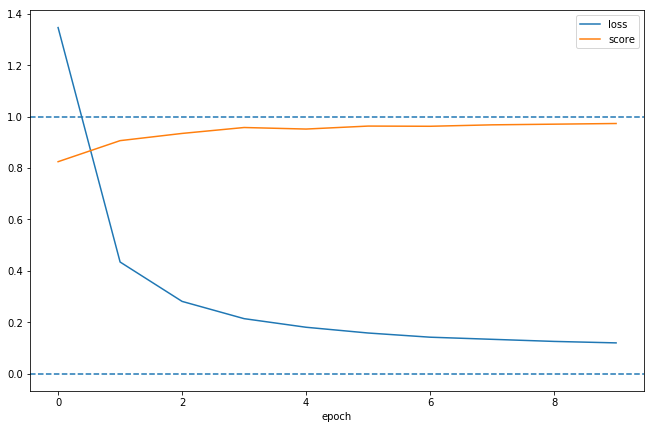

In [10]:
plt.figure(figsize=(11, 7))

for metric in ['loss', 'score']:
    (pd.concat({d['epoch']: pd.Series(d[metric], name=metric)
                for d in losses_scores},
               names=['epoch'])
     .groupby('epoch').mean()
     .plot(label=metric))

plt.axhline(0, ls='--')
plt.axhline(1, ls='--')
plt.legend();

# Create submission file

In [11]:
test_data = MNIST('C:/Users/dell/Desktop/mnist/test.csv', train=False)
images = torch.Tensor(test_data.images)
logits = model.to('cpu')(images)
_, y_pred = torch.max(logits, dim=1)

In [12]:
submission = pd.DataFrame({'ImageId': np.arange(len(y_pred)) + 1, 'Label': y_pred})
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,2
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [13]:
submission.to_csv('C:/Users/dell/Desktop/mnist/submission.csv', index=False)

In [14]:
y_pred.shape

torch.Size([28000])